# Debugging Initial Conditions: Plotting


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4

In [2]:
# define the input directory
input_dir = 'F:\project\input'

## Constructing the Initial Conditions
For my model, I will use a model state from the ECCO Version 5 state estimate. I will prepare the initial condition fields in 7 steps:
1. download 5 fields and 4 grid files generated by the ECCO model in 2008
2. read the ECCO model grid
3. read in the bathymetry for my model as well as its grid
4. prepare the ECCO fields for interpolation
5. interpolate the ECCO fields onto my model grid and store each as a binary file
6. plot the interpolated fields to ensure they look as expected
7. prepare notes on the run-time options I will use to implement my initial condition approach

### Step 1: Download the ECCO fields
To begin, I downloaded the model fields generated by the ECCO Version 5 Alpha state estimate. These fields are available [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/nctiles_monthly). In particular, I downloaded the following list of files that contain the field pertaining to starting point of my model (January 2008):

| Variable | File Name |
| -------- | --------- |
|THETA|THETA/THETA_2008.nc|
|SALT|SALT/SALT_2008.nc|
|UVEL|UVELMASS/UVELMASS_2008.nc|
|VVEL|VVELMASS/VVELMASS_2008.nc|
|ETAN|ETHAN/ETAN_2008.nc|

I stored these fields in the following directory:

In [3]:
data_folder = 'D:\data'

### Model Grid

In [37]:
# define the parameters that will be used in the data file
delX = 1/12
delY = 1/16
xgOrigin = -98
ygOrigin = 17
n_rows = 240
n_cols = 240

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'Gulf_Mexico_Bathymetry_Florida.bin'),'>f4').reshape(np.shape(XC))

With an eye toward the interpolation to come next, I will make a mask to determine where the interpolatation will take place. I will create this mask by recreating the `hFac` field for my model using the `hFac` module from the `eccoseas` package: 

In [5]:
from eccoseas.downscale import hFac

In [6]:
depth = bathy
delR = np.array([ 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.01,
                 10.03, 10.11, 10.32, 10.80, 11.76, 13.42, 16.04, 19.82, 24.85,
                 31.10, 38.42, 46.50, 55.00, 63.50, 71.58, 78.90, 85.15, 90.18,
                 93.96, 96.58, 98.25, 99.25,100.01,101.33,104.56,111.33,122.83,
                 139.09,158.94,180.83,203.55,226.50,249.50,272.50,295.50,318.50,
                 341.50,364.50,387.50,410.50,433.50,456.50,])
hFacC = hFac.create_hFacC_grid(depth, delR)

The mask is generated by setting all of the non-zero `hFac` points to 1:

In [7]:
mask = np.copy(hFacC)
mask[mask>0] = 1

To double check the mask was created as expected, I will plot it in comparison to the bathymetry here:

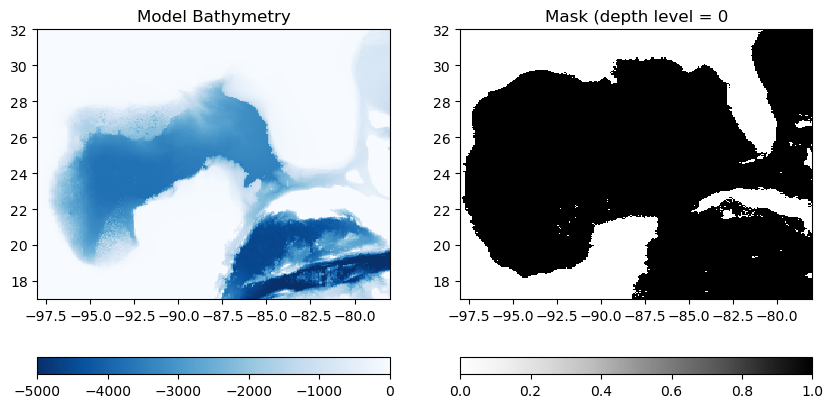

In [8]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

depth_level = 0
plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, mask[0], vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Mask (depth level = '+str(depth_level))

plt.show()

Seems reasonable!

Next, we'll read in the real data fields and apply the modifications. First, create a dictionary to store the file names:

### Plotting the Cross Sections

In [26]:
# make a file dictionary to loop over
file_prefix_dict = {#'ETAN':'ETAN_2015.nc',
                    'THETA':'THETA_2015.nc',
                    'SALT':'SALT_2015.nc',
                    'UVEL':'UVELMASS_2015.nc',
                    'VVEL':'VVELMASS_2015.nc'}
variable_names = list(file_prefix_dict.keys())

In [10]:
meta_dict = {'ETAN':[0.1, 0.5, 'viridis', 'm'],
            'THETA':[20, 28, 'turbo', 'm'],
            'SALT':[36, 37, 'viridis', 'm'],
            'UVEL':[-0.5, 0.5, 'seismic', 'm'],
            'VVEL':[-0.5, 0.5, 'seismic', 'm']}

Then, I'll create all of the subplots:

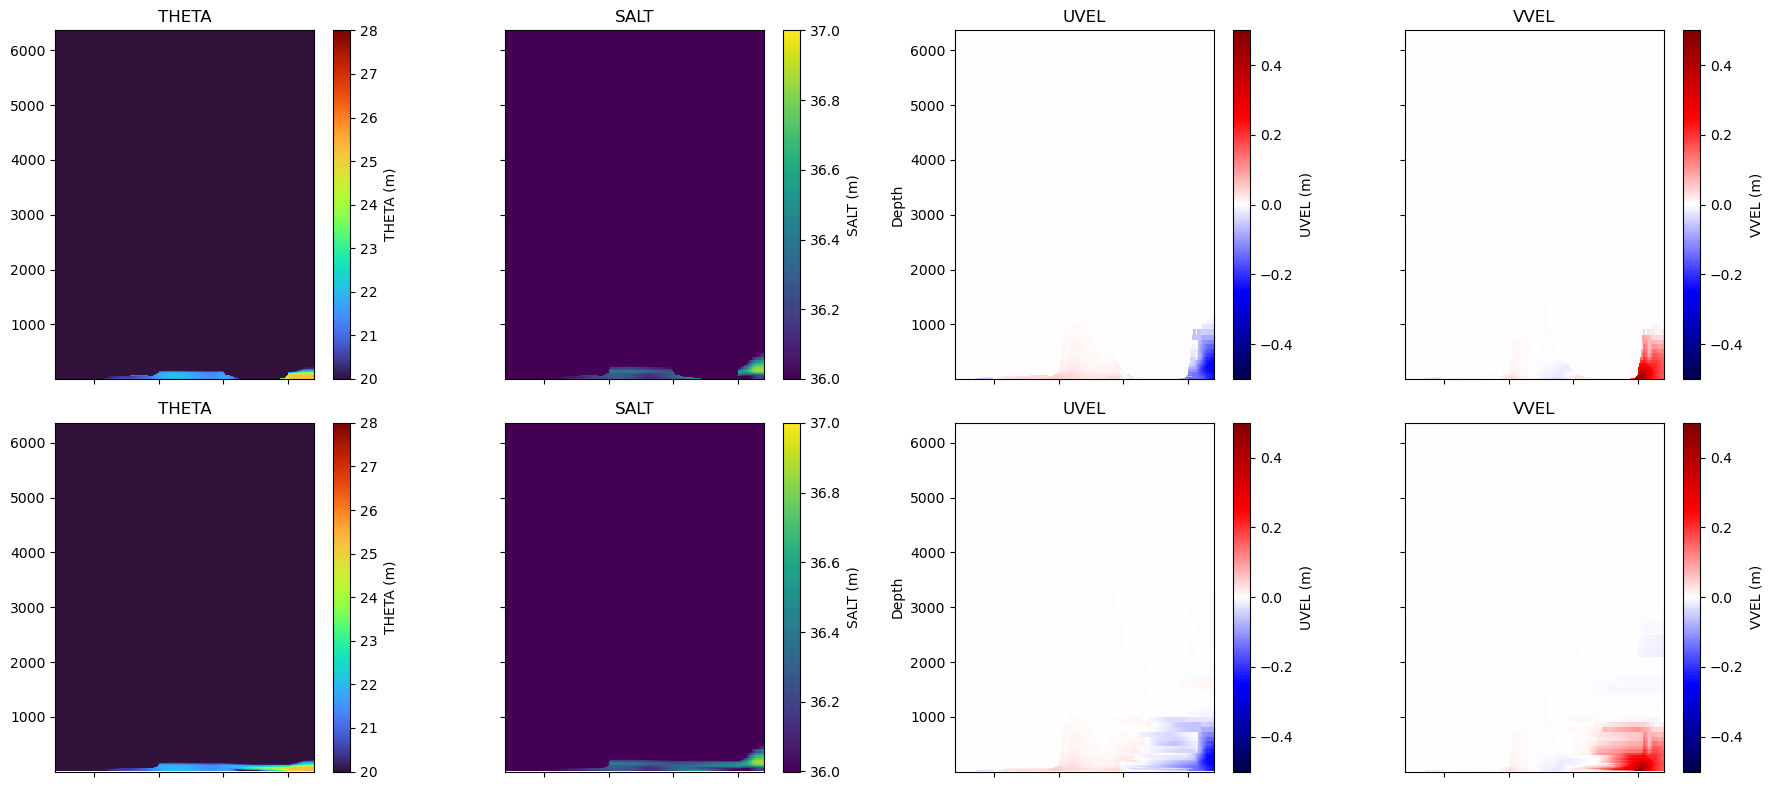

In [62]:
fig = plt.figure(figsize=(18,8))
florida_dir='initial_florida'
no_florida_dir='initial_no_florida'
dirs = ['initial_florida', 'initial_no_florida']
for j in range(0, 5, 4):
    for i in range(len(variable_names)):
        variable_name = variable_names[i]
        
        CA_init_grid = np.fromfile(os.path.join(input_dir,dirs[j//4],variable_name+'_IC.bin'),'>f4')
        CA_init_grid = CA_init_grid.reshape((np.shape(delR)[0],np.shape(XC)[0], np.shape(XC)[1])) # Shape: 50,240,240
        CA_init_grid = CA_init_grid[:, 180, :] # choose a vertical plane cutting through Florida
        
        XC_slice = XC[180, :]  # Shape (240,)
        Y = np.cumsum(delR)[:, None]  # Shape (50, 1)
        #print(Y)
        X, Y = np.meshgrid(XC_slice, np.cumsum(delR))  # Shapes: X (50, 240), Y (50, 240)
        
        
        plt.subplot(2,4,i+j+1)
        C = plt.pcolormesh(X, Y, CA_init_grid,
                       vmin=meta_dict[variable_names[i]][0],
                       vmax=meta_dict[variable_names[i]][1],
                       cmap=meta_dict[variable_names[i]][2])
        plt.colorbar(C, label=variable_names[i]+' ('+meta_dict[variable_names[i]][3]+')',fraction=0.26)
    
        if i<5:
            plt.gca().set_xticklabels([])
        else:
            plt.gca().set_xlabel('Longitude')
        if i%2==1:
            plt.gca().set_yticklabels([])
        if i==7:
            plt.gca().axis('off')
        if i==2:
            plt.gca().set_ylabel('Depth')
        plt.title(variable_name)

plt.tight_layout()

plt.show()